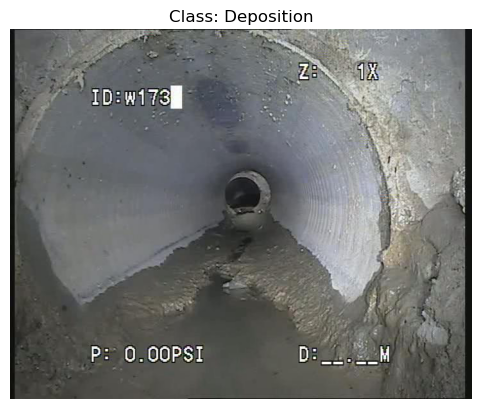

In [40]:
import os
import random
import yaml
from PIL import Image
import matplotlib.pyplot as plt

# Caminhos para os diretórios
images_path = r'C:\Users\lidia\OneDrive\Área de Trabalho\Mestrado\Visão Computacional\pipeline_dataset\images\images\train'
labels_path = r'C:\Users\lidia\OneDrive\Área de Trabalho\Mestrado\Visão Computacional\pipeline_dataset\labels\labels\train'
config_path = r'C:\Users\lidia\OneDrive\Área de Trabalho\Mestrado\Visão Computacional\pipeline_dataset\config.yaml'

# Carregar o arquivo de configuração
with open(config_path, 'r') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

# Mapeamento das classes
class_names = config['names']

# Obter lista de arquivos de imagens
image_files = os.listdir(images_path)

# Selecionar uma imagem aleatória
random_image = random.choice(image_files)

# Carregar a imagem usando PIL
image_path = os.path.join(images_path, random_image)
image = Image.open(image_path)

# Obter o nome do arquivo da label correspondente
label_file = random_image.replace('.jpg', '.txt')  # Ajuste conforme o formato real
label_path = os.path.join(labels_path, label_file)

# Carregar a label e extrair a classe (primeiro número da linha)
with open(label_path, 'r') as file:
    line = file.readline().strip()
    label = int(line.split()[0])  # Extrair apenas o índice da classe

# Exibir a imagem com a classificação
plt.imshow(image)
plt.title(f'Class: {class_names[label]}')
plt.axis('off')  # Desabilitar os eixos
plt.show()


In [5]:
from PIL import Image
import os

# Caminho das imagens
images_path = r'C:\Users\lidia\OneDrive\Área de Trabalho\Mestrado\Visão Computacional\pipeline_dataset\images\images\train'

# Obter uma lista de arquivos de imagem
image_files = os.listdir(images_path)

# Escolher uma imagem aleatória ou a primeira da lista
sample_image_path = os.path.join(images_path, image_files[0])

# Abrir a imagem
with Image.open(sample_image_path) as img:
    width, height = img.size
    print(f"Dimensões da imagem: {width}x{height} (Largura x Altura)")
    print(f"Formato: {img.format}")  # Ex: JPEG, PNG
    print(f"Modo de cor: {img.mode}")  # Ex: RGB, L



Dimensões da imagem: 720x576 (Largura x Altura)
Formato: JPEG
Modo de cor: RGB


In [2]:
dimensions = []
for image_file in image_files:
    image_path = os.path.join(images_path, image_file)
    with Image.open(image_path) as img:
        dimensions.append(img.size)

# Exibir as dimensões únicas
unique_dimensions = set(dimensions)
print(f"Dimensões únicas das imagens: {unique_dimensions}")


Dimensões únicas das imagens: {(704, 576), (511, 383), (616, 347), (625, 469), (462, 347), (400, 400), (580, 464), (520, 416), (640, 368), (608, 486), (567, 454), (509, 382), (589, 442), (609, 487), (584, 467), (789, 631), (450, 338), (640, 480), (582, 466), (720, 540), (462, 260), (875, 700), (539, 303), (320, 240), (720, 576), (480, 360), (704, 528), (518, 414), (816, 653), (640, 360), (481, 385)}


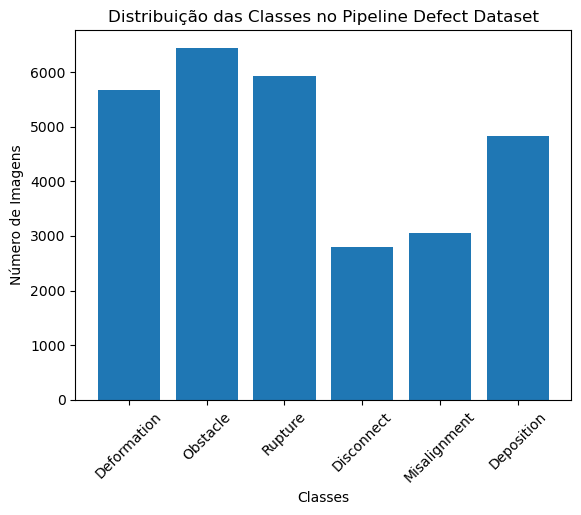

Deformation: 5676 imagens
Obstacle: 6441 imagens
Rupture: 5933 imagens
Disconnect: 2804 imagens
Misalignment: 3056 imagens
Deposition: 4820 imagens


In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np

# Caminho para os arquivos de labels
labels_path = r'C:\Users\lidia\OneDrive\Área de Trabalho\Mestrado\Visão Computacional\pipeline_dataset\labels\labels\train'

# Inicializar contadores para as classes
class_counts = np.zeros(6, dtype=int)

# Percorrer todos os arquivos de labels
for label_file in os.listdir(labels_path):
    file_path = os.path.join(labels_path, label_file)
    with open(file_path, 'r') as file:
        for line in file:
            class_index = int(line.split()[0])  # Pegar o índice da classe
            class_counts[class_index] += 1

# Nomes das classes
class_names = ['Deformation', 'Obstacle', 'Rupture', 'Disconnect', 'Misalignment', 'Deposition']

# Plotar o gráfico de barras
plt.bar(class_names, class_counts)
plt.xlabel('Classes')
plt.ylabel('Número de Imagens')
plt.title('Distribuição das Classes no Pipeline Defect Dataset')
plt.xticks(rotation=45)
plt.show()

# Exibir contagem por classe
for i, count in enumerate(class_counts):
    print(f"{class_names[i]}: {count} imagens")


In [ ]:
import os
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K

# Função para calcular F1-Score diretamente como métrica
def f1_score_metric(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')  # Garantir que y_true seja float32
    y_pred = K.cast(y_pred, 'float32')  # Garantir que y_pred seja float32
    return K.mean(2 * (y_true * y_pred) / (y_true + y_pred + K.epsilon()))

# Caminhos
images_path = r'C:\Users\lidia\OneDrive\Área de Trabalho\Mestrado\Visão Computacional\pipeline_dataset\images\images\train'
labels_path = r'C:\Users\lidia\OneDrive\Área de Trabalho\Mestrado\Visão Computacional\pipeline_dataset\labels\labels\train'

# Função para carregar e processar imagens
def load_and_process_images(images_path, labels_path, img_size=(256, 256)):
    image_files = os.listdir(images_path)
    images, labels = [], []

    for image_file in image_files:
        img = Image.open(os.path.join(images_path, image_file)).resize(img_size)
        img = np.array(img, dtype=np.float32) / 255.0
        
        label_file = image_file.replace('.jpg', '.txt')
        with open(os.path.join(labels_path, label_file), 'r') as f:
            label = int(f.readline().split()[0]) == 2  # Classe "Rupture" = 1, outros = 0

        images.append(img)
        labels.append(label)
    
    return np.array(images), np.array(labels)

# Carregar dados
X, y = load_and_process_images(images_path, labels_path)

# Divisão dos dados
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Data Augmentation
train_datagen = ImageDataGenerator(horizontal_flip=True, rotation_range=20, width_shift_range=0.1, height_shift_range=0.1)
val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)  # Ajuste para batch_size fixo
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

# Modelo CNN atualizado
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.5),

    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(1, activation='sigmoid')
])

# Compilação
model.compile(optimizer=Adam(learning_rate=0.0001), loss=BinaryCrossentropy(), 
              metrics=['accuracy', 'Precision', 'Recall', f1_score_metric])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
callbacks = [early_stopping]

# Treinamento
model.fit(train_generator, validation_data=val_generator, epochs=20, callbacks=callbacks)

# Avaliação no conjunto de teste
test_metrics = model.evaluate(val_generator)

# Exibindo os valores das métricas
print(f"Test Loss: {test_metrics[0]}")
print(f"Test Accuracy: {test_metrics[1]}")
print(f"Test Precision: {test_metrics[2]}")
print(f"Test Recall: {test_metrics[3]}")
print(f"Test F1-Score: {test_metrics[4]}")

/opt/conda/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
484/484 ━━━━━━━━━━━━━━━━━━━━ 179s 363ms/step - Precision: 0.2294 - Recall: 0.5338 - accuracy: 0.5813 - f1_score_metric: 0.1050 - loss: 0.8707 - val_Precision: 0.1585 - val_Recall: 0.0631 - val_accuracy: 0.7631 - val_f1_score_metric: 0.0325 - val_loss: 1.2998
Epoch 2/20
484/484 ━━━━━━━━━━━━━━━━━━━━ 186s 384ms/step - Precision: 0.2672 - Recall: 0.3376 - accuracy: 0.7020 - f1_score_metric: 0.0853 - loss: 0.6159 - val_Precision: 0.1885 - val_Recall: 0.3608 - val_accuracy: 0.5916 - val_f1_score_metric: 0.0798 - val_loss: 3.2923
Epoch 3/20
484/484 ━━━━━━━━━━━━━━━━━━━━ 169s 350ms/step - Precision: 0.2927 - Recall: 0.2115 - accuracy: 0.7579 - f1_score_metric: 0.0675 - loss: 0.5409 - val_Precision: 0.1761 - val_Recall: 0.1359 - val_accuracy: 0.7206 - val_f1_score_metric: 0.0455 - val_loss: 2.5603
Epoch 4/20
484/484 ━━━━━━━━━━━━━━━━━━━━ 176s 364ms/step - Precision: 0.3468 - Recall: 0.1697 - accuracy: 0.7831 - f1_score_metric: 0.0596 - loss: 0.5097 - val_Precision: 0.1768 - val_Recall:

### Avaliação do Modelo

As métricas obtidas foram:

- **Test Loss**: 0.4534
- **Test Accuracy**: 81.77%
- **Test Precision**: 52.38%
- **Test Recall**: 23.14%
- **Test F1-Score**: 5.57%

### Interpretação das Métricas

1. **Test Loss (0.4534)**: O valor da perda (loss) sugere que o modelo tem um erro moderado, mas não é tão alto quanto poderia ser. Uma perda mais baixa geralmente indica uma boa capacidade de previsão do modelo, embora o fato de o F1-Score estar baixo sugira que o modelo pode não estar se saindo bem nas classes que são mais difíceis de prever (especialmente "Ruptura").

2. **Test Accuracy (81.77%)**: A precisão do modelo parece razoavelmente boa, com mais de 80% das previsões corretas no geral. No entanto, a acurácia isoladamente não é uma métrica ideal para avaliar modelos desbalanceados. Isso pode significar que o modelo está prevendo corretamente as classes majoritárias, mas isso não é suficiente para avaliar sua eficácia no reconhecimento do defeito de "Ruptura".

3. **Test Precision (52.38%)**: A precisão (Precision) indica que, entre todas as previsões feitas pelo modelo para a classe "Ruptura", aproximadamente 52.38% estavam corretas. Isso sugere que o modelo é razoavelmente bom em evitar falsos positivos para a classe "Ruptura". No entanto, essa precisão ainda pode ser melhorada, especialmente para identificar mais corretamente a classe "Ruptura".

4. **Test Recall (23.14%)**: O recall muito baixo indica que o modelo está perdendo muitas instâncias da classe "Ruptura". Ou seja, ele não está identificando adequadamente as imagens que realmente contêm o defeito "Ruptura", resultando em muitos falsos negativos.

5. **Test F1-Score (5.57%)**: O F1-Score, que é uma média harmônica entre precisão e recall, está muito baixo. Isso é um indicativo de que o modelo está com um desempenho fraco na identificação da classe "Ruptura", principalmente devido ao recall baixo. O F1-Score é particularmente importante quando estamos lidando com classes desbalanceadas, pois ele leva em consideração tanto falsos positivos quanto falsos negativos.

### Expectativas e Comportamento

- **Acurácia Alta, mas F1-Score Baixo**: A alta acurácia e a baixa pontuação de F1 indicam que o modelo pode estar classificando corretamente a maioria das imagens da classe negativa (não "Ruptura"), mas está falhando em identificar corretamente as imagens com o defeito "Ruptura". Isso é típico em problemas de classificação desbalanceada, onde o modelo tende a ser mais conservador em prever a classe majoritária.
  
- **Recall Baixo**: Um recall baixo sugere que o modelo tem dificuldades em identificar a classe positiva, ou seja, "Ruptura". Isso é um indicativo claro de que o modelo não está suficientemente treinado ou que existem fatores no conjunto de dados que dificultam a aprendizagem dessa classe.

### Possíveis Modificações para Melhorar os Resultados

1. **Ajuste de Balanceamento de Classes**:
   - **Data Augmentation específico para "Ruptura"**: Aumentar o número de imagens da classe "Ruptura" por meio de técnicas específicas de augmentação pode ajudar o modelo a aprender melhor as características dessa classe. Além de flips e rotações, pode-se usar variações adicionais que mantenham a estrutura da classe "Ruptura".
   - **Reamostragem (Oversampling/Undersampling)**: Técnicas de reamostragem podem ser aplicadas para balancear as classes. No caso de undersampling, a quantidade de imagens da classe majoritária pode ser reduzida. No caso de oversampling, podem ser geradas cópias adicionais ou modificações das imagens da classe "Ruptura" para melhorar o aprendizado.

2. **Mudanças no Modelo**:
   - **Arquitetura mais Profunda ou Complexa**: O modelo atual pode ser simples demais para capturar as características complexas das imagens de defeito. Tentar uma rede mais profunda com mais camadas convolucionais pode permitir que o modelo extraia representações mais complexas das imagens.
   - **Camadas adicionais de Dropout**: Para evitar overfitting e ajudar o modelo a generalizar melhor, pode-se adicionar mais camadas de Dropout ou ajustar a taxa de dropout.
   - **Alteração da Função de Ativação**: Considerar o uso de outras funções de ativação, como LeakyReLU, em vez de ReLU, pode ajudar a melhorar a performance em algumas redes convolucionais, especialmente em modelos que estão tendo dificuldades com o aprendizado.

3. **Ajuste de Hiperparâmetros**:
   - **Ajuste da Taxa de Aprendizado**: A taxa de aprendizado de 0.0001 pode ser muito baixa para um modelo com grande complexidade. Aumentá-la um pouco pode acelerar o treinamento sem causar overfitting.
   - **Ajuste de `batch_size`**: Experimentar diferentes valores de `batch_size` pode afetar o desempenho do modelo. Um valor muito grande pode fazer com que o modelo generalize pior, enquanto um valor muito pequeno pode tornar o treinamento mais ruidoso.

4. **Métricas e Avaliação de Desempenho**:
   - **Acompanhamento de Mais Métricas**: Incluir mais métricas como a curva ROC e a área sob a curva (AUC) pode fornecer mais insights sobre o desempenho do modelo, especialmente em problemas desbalanceados.
   - **Confusion Matrix**: Exibir a matriz de confusão pode ajudar a identificar melhor onde o modelo está cometendo os erros (por exemplo, se está confundindo as classes negativas com as positivas).

5. **Uso de Modelos Pré-treinados (Transfer Learning)**:
   - **Transfer Learning**: Usar modelos pré-treinados, como VGG16, ResNet, ou Inception, e adaptar sua última camada para o problema de classificação binária pode acelerar o treinamento e melhorar o desempenho, especialmente se o dataset for pequeno.

### Conclusão

O modelo apresenta bons resultados em termos de acurácia, mas falha em identificar corretamente a classe "Ruptura", como evidenciado pelo baixo recall e F1-Score. As modificações sugeridas, como balanceamento de classes, ajuste da arquitetura do modelo, e uso de técnicas de transferência de aprendizado, são passos importantes para melhorar o desempenho, especialmente no reconhecimento da classe "Ruptura".
